In [1]:
!pip install pyreadstat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.2 MB/s eta 0:00:00


In [2]:
pip install xgboost

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pyreadstat
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.feature_selection import SelectFromModel


In [5]:
directory_path = '/content/drive/MyDrive/SOP-Entrepreneur'

# Change the current working directory to the specified directory
os.chdir(directory_path)
print(os.listdir())

['GEM_2019_APS_Global_Individual_Level Data_30Jan2021.sav', 'GEM 2017 APS Global Individual Level Data_1April2021.sav', 'Papers', 'Entrepreneur_Intention.ipynb', 'decision_tree', 'decision_tree.pdf', 'Entrepreneur_Intention_Income.ipynb']


# Data Cleaning

In [6]:
file_path = 'GEM_2019_APS_Global_Individual_Level Data_30Jan2021.sav'
# file_path2 = 'GEM 2018 APS Global Individual Level Data.sav'
# Read the SPSS file
df, meta = pyreadstat.read_sav(file_path)


In [7]:
# print(df2.head())
# for column in df2.columns:
#     column_label = meta.variable_to_label.get(f'{column}')
#     print(f"Label of column '{column}': ", column_label)

In [8]:
# dataframe with required columns
# df_var_columns = df[['age','gender','hhsize','UNEDUC','knowentR','opportL','suskillL','fearfailL',
                      # 'easystartL','oppismL','proactL','creativL','visionL','futsup','nbgoodcL','INDSUPyy','FUTSUPNO']]

df_var_columns2019 = df[['age','gender','hhsize','UNEDUC','knowentR','opportL','suskillL','fearfailL'
                    ,'oppismL','proactL','creativL','visionL', 'nbgoodcL', 'nbstatusL','FUTSUPNO', 'GEMHHINC']]

# df_var_columns2018 = df2[['age','gender','hhsize','UNEDUC','knowent','opport','suskill','fearfail'
#                     ,'oppismL','proactL','creativL','visionL', 'nbgoodc', 'nbstatus','FUTSUPNO']]

In [9]:
print(df_var_columns2019.head())

    age  gender  hhsize  UNEDUC  knowentR  opportL  suskillL  fearfailL  \
0  73.0     1.0     2.0     6.0       0.0      3.0       5.0        1.0   
1  43.0     1.0     4.0     6.0       2.0      2.0       5.0        1.0   
2  64.0     2.0     2.0     3.0       0.0      5.0       2.0        1.0   
3  70.0     2.0     2.0     7.0       1.0      1.0       5.0        1.0   
4  63.0     1.0     2.0     6.0       0.0      2.0       4.0        4.0   

   oppismL  proactL  creativL  visionL  nbgoodcL  nbstatusL  FUTSUPNO  \
0      1.0      1.0       4.0      1.0       1.0        4.0       NaN   
1      2.0      1.0       4.0      4.0       5.0        3.0       NaN   
2      1.0      4.0       4.0      5.0       2.0        5.0       0.0   
3      2.0      2.0       4.0      5.0       5.0        4.0       0.0   
4      1.0      4.0       5.0      5.0       4.0        4.0       0.0   

   GEMHHINC  
0   68100.0  
1   68100.0  
2      33.0  
3   68100.0  
4      33.0  


In [10]:
df_35_below = df_var_columns2019[df_var_columns2019['age'] < 36]
df_35_bel_wo_age = df_35_below.drop(columns=['age'])
df_clean = df_35_bel_wo_age.dropna()

df_lowInc = df_clean[df_clean['GEMHHINC'] == 33.0]
df_midInc = df_clean[df_clean['GEMHHINC'] == 3467.0]
df_highInc = df_clean[df_clean['GEMHHINC'] == 68100.0]

print(df_clean.head())

    gender  hhsize  UNEDUC  knowentR  opportL  suskillL  fearfailL  oppismL  \
21     1.0     4.0     4.0       0.0      4.0       5.0        4.0      2.0   
24     2.0     1.0     6.0       0.0      1.0       4.0        5.0      5.0   
32     2.0     3.0     6.0       2.0      1.0       1.0        5.0      2.0   
49     2.0     2.0     2.0       0.0      2.0       1.0        2.0      2.0   
64     1.0     4.0     6.0       0.0      4.0       2.0        3.0      3.0   

    proactL  creativL  visionL  nbgoodcL  nbstatusL  FUTSUPNO  GEMHHINC  
21      4.0       4.0      2.0       3.0        4.0       0.0    3467.0  
24      4.0       5.0      5.0       4.0        4.0       0.0      33.0  
32      5.0       4.0      5.0       4.0        5.0       0.0      33.0  
49      2.0       4.0      2.0       2.0        4.0       0.0      33.0  
64      3.0       3.0      2.0       3.0        4.0       0.0    3467.0  


# Descriptive Statistics

In [11]:
# Get the total entries in each DataFrame
total_entries = [df.shape[0] for df in [df_lowInc, df_midInc, df_highInc]]

# Print total entries for each DataFrame
for i, total in enumerate(total_entries):
    print(f"Total entries in DataFrame {i + 1}: {total}")

# Get frequency table for all columns
frequency_tables = [{}, {}, {}]

# Iterate over each DataFrame
for i, df in enumerate([df_lowInc, df_midInc, df_highInc]):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Store frequency values for the current column in the respective frequency table
        frequency_tables[i][column] = df[column].value_counts()

# Print frequency tables for all columns
for i, frequency_table in enumerate(frequency_tables):
    print(f"Frequency tables for DataFrame {i + 1}:")
    for column, table in frequency_table.items():
        if column != "age" and column != "hhsize":
            print(f"Column: {column}")
            print(table)
            print()  # Print an empty line for better readability



Total entries in DataFrame 1: 10365
Total entries in DataFrame 2: 10452
Total entries in DataFrame 3: 9588
Frequency tables for DataFrame 1:
Column: gender
gender
2.0    5429
1.0    4936
Name: count, dtype: int64

Column: UNEDUC
UNEDUC
3.0    3266
6.0    1858
2.0    1840
4.0    1428
1.0     689
5.0     555
7.0     484
0.0     226
8.0      19
Name: count, dtype: int64

Column: knowentR
knowentR
0.0    5194
2.0    2317
1.0    2053
3.0     801
Name: count, dtype: int64

Column: opportL
opportL
4.0    3010
1.0    2032
2.0    2014
5.0    1897
3.0    1412
Name: count, dtype: int64

Column: suskillL
suskillL
4.0    2940
1.0    2190
5.0    2104
2.0    2054
3.0    1077
Name: count, dtype: int64

Column: fearfailL
fearfailL
4.0    2721
5.0    2517
1.0    2095
2.0    1917
3.0    1115
Name: count, dtype: int64

Column: oppismL
oppismL
4.0    3507
5.0    1995
2.0    1956
3.0    1710
1.0    1197
Name: count, dtype: int64

Column: proactL
proactL
4.0    3188
5.0    2385
2.0    2000
1.0    1417
3.0   

# Data preparation for Model (Test and Training Data)

SMOTE performed to handle class imbalances

In [12]:
# # X contains features (independent variables), y contains the target variable (dependent variable)
# X = df_clean.drop(columns=['FUTSUPNO'])
# y = df_clean['FUTSUPNO']

# # Split Data into Training and Testing Sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Functions for Data analysis and Visualization

In [13]:
def gen_report_accuracy(y_test, y_pred):
  #  accuracy score
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy*100, "%")

  #  classification report
  report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(report)


def roc_auc_calc(clf,y_test,):
  # predictions on the testing data
  y_pred_proba = clf.predict_proba(X_test)[:,1]  # Probability estimates of the positive class

  #  AUC-ROC score
  auc_roc = roc_auc_score(y_test, y_pred_proba)
  print(f"AUC-ROC Score: {auc_roc}")

  #  ROC curve calc
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  #  ROC curve
  plt.figure(figsize=(4, 3))
  plt.plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % auc_roc)
  plt.plot([0, 1], [0, 1], color='red', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()
  print()


def confusM(y_test, y_pred):
  # Calculate confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix as heatmap
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()
  print()


def var_importance(clf, X_train, name):
  # Get feature importances
  importances = clf.feature_importances_

  # Get the names of features
  feature_names = X_train.columns

  # Sort feature importances in descending order
  sorted_indices = importances.argsort()[::-1]
  sorted_importances = importances[sorted_indices]
  sorted_feature_names = feature_names[sorted_indices]

  # Plot feature importances
  plt.figure(figsize=(4, 3))
  plt.bar(range(X_train.shape[1]), sorted_importances, tick_label=sorted_feature_names)
  plt.xticks(rotation=90)
  plt.xlabel('Feature')
  plt.ylabel('Importance Score')
  plt.title(f'Variable Importance Scores ({name})')
  plt.show()
  print()

# Implementing all 3 economy types on Decision Trees

Running model on DataFrame 1
Accuracy: 62.636655948553056 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73      2203
         1.0       0.37      0.39      0.38       907

    accuracy                           0.63      3110
   macro avg       0.55      0.56      0.56      3110
weighted avg       0.63      0.63      0.63      3110

AUC-ROC Score: 0.5564317676457031


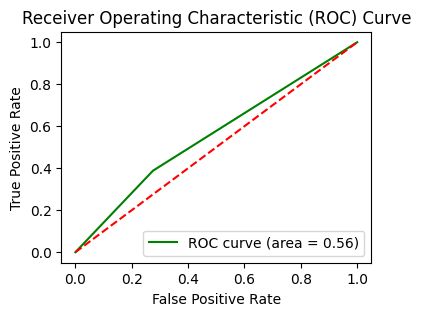

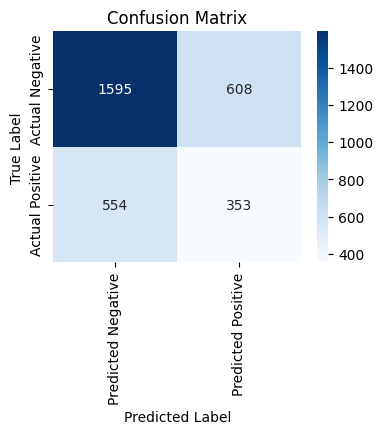

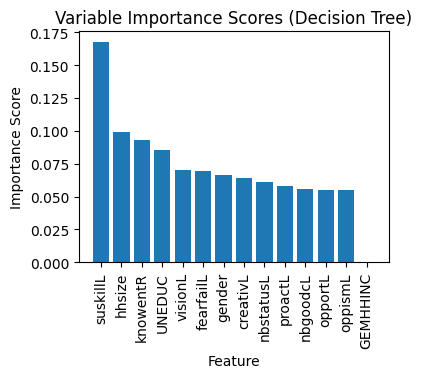


Running model on DataFrame 2
Accuracy: 63.01020408163265 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.73      0.73      2210
         1.0       0.38      0.40      0.39       926

    accuracy                           0.63      3136
   macro avg       0.56      0.56      0.56      3136
weighted avg       0.64      0.63      0.63      3136

AUC-ROC Score: 0.5624888832422817


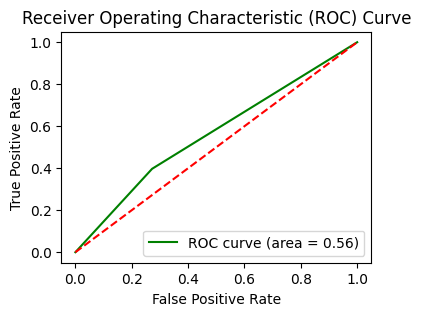

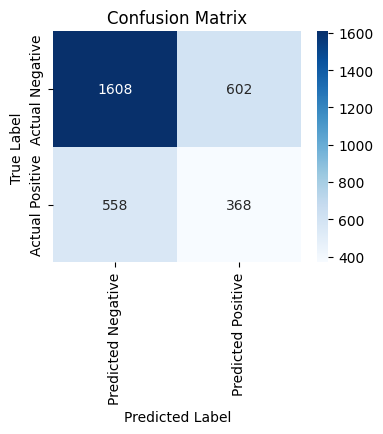

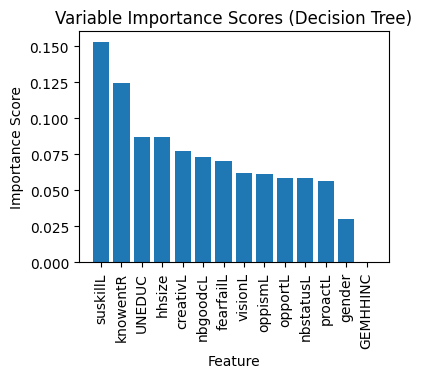


Running model on DataFrame 3
Accuracy: 63.7817170663886 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      2049
         1.0       0.38      0.40      0.39       828

    accuracy                           0.64      2877
   macro avg       0.57      0.57      0.57      2877
weighted avg       0.64      0.64      0.64      2877

AUC-ROC Score: 0.5679670535644818


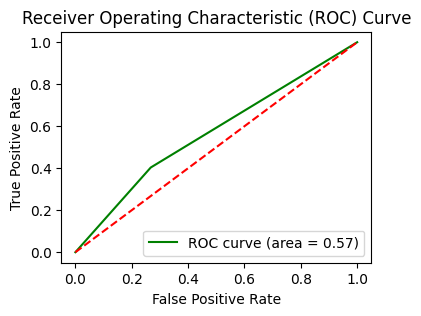

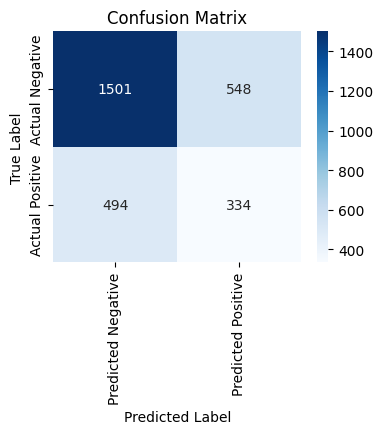

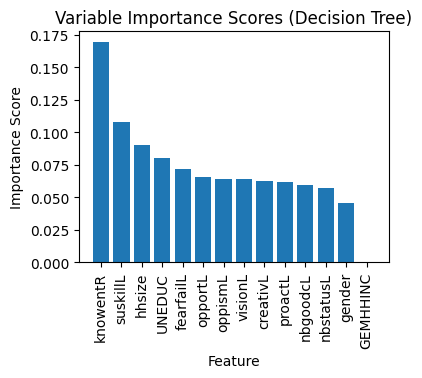

In [14]:
# Define a list of DataFrames
dfs = [df_lowInc, df_midInc, df_highInc]

# Loop over each DataFrame
for i, df in enumerate(dfs):
    print(f"Running model on DataFrame {i + 1}")

    # X contains features (independent variables), y contains the target variable (dependent variable)
    X = df.drop(columns=['FUTSUPNO'])
    y = df['FUTSUPNO']

    # Split Data into Training and Testing Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Initialize and train your model (e.g., DecisionTreeClassifier)
    clf = DecisionTreeClassifier(random_state=42)

    clf.fit(X_resampled, y_resampled)

    #  predictions on the testing data
    y_pred = clf.predict(X_test)

    # report
    gen_report_accuracy(y_test, y_pred)

    # AUC ROC
    roc_auc_calc(clf,y_test)

    # confusion Matrix
    confusM(y_test, y_pred)

    # Variable importance
    var_importance(clf, X_resampled,"Decision Tree")

In [15]:
# Select top 5-6 features based on their importance
feature_selector = SelectFromModel(clf, prefit=True, max_features=6)
X_selected = feature_selector.transform(X)

# Get the selected feature names
selected_feature_names = X.columns[feature_selector.get_support()]

# Train the decision tree classifier using selected features
clf_selected = DecisionTreeClassifier()
clf_selected.fit(X_selected, y)

# # Export the decision tree to a DOT file
# dot_data_selected = export_graphviz(clf_selected, out_file=None,
#                                     feature_names=selected_feature_names,
#                                     class_names=['No Support', 'Support'],
#                                     filled=True, rounded=True,
#                                     special_characters=True)


# # Render the graph
# graph = graphviz.Source(dot_data)
# # Display the decision tree
# graph.render("decision_tree")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


NameError: name 'dot_data' is not defined

# Implementing the 3 economy types on Random forest

Running model on DataFrame 1
Accuracy: 71.57556270096464 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.91      0.82      2203
         1.0       0.53      0.24      0.33       907

    accuracy                           0.72      3110
   macro avg       0.64      0.58      0.58      3110
weighted avg       0.68      0.72      0.68      3110



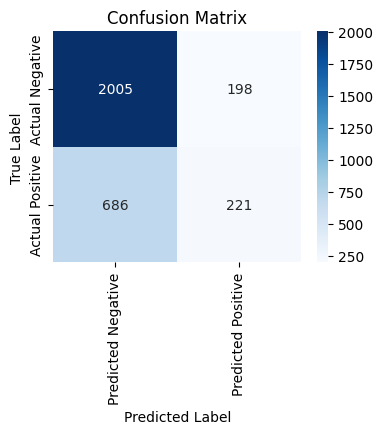


AUC-ROC Score: 0.6860875792807342


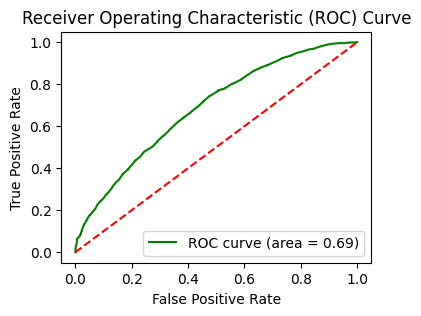

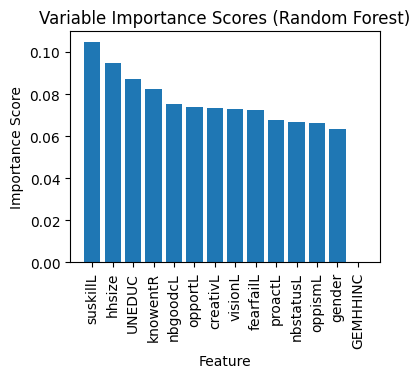


Running model on DataFrame 2
Accuracy: 71.93877551020408 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82      2210
         1.0       0.54      0.30      0.39       926

    accuracy                           0.72      3136
   macro avg       0.65      0.60      0.60      3136
weighted avg       0.69      0.72      0.69      3136



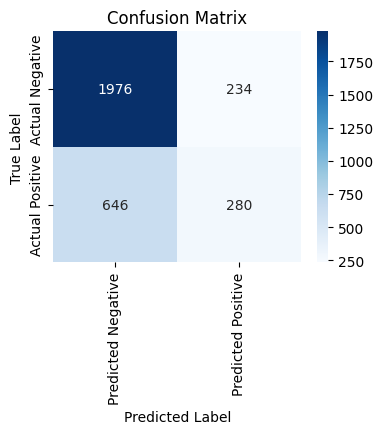


AUC-ROC Score: 0.698412380403233


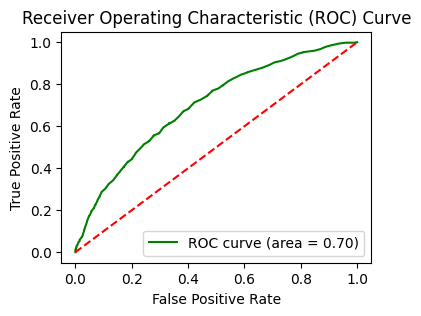

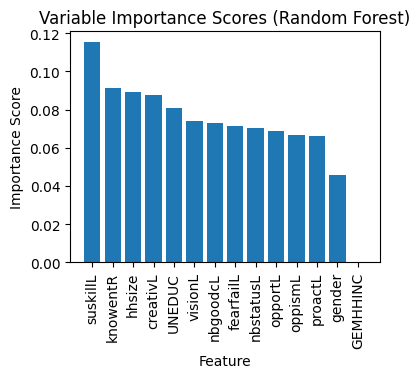


Running model on DataFrame 3
Accuracy: 71.18526242613834 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      2049
         1.0       0.50      0.24      0.32       828

    accuracy                           0.71      2877
   macro avg       0.62      0.57      0.57      2877
weighted avg       0.67      0.71      0.67      2877



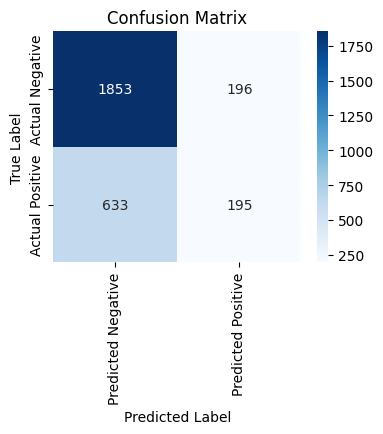


AUC-ROC Score: 0.7163005755134473


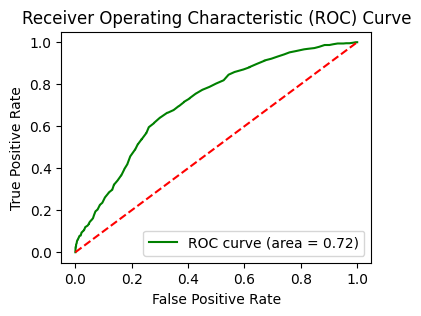

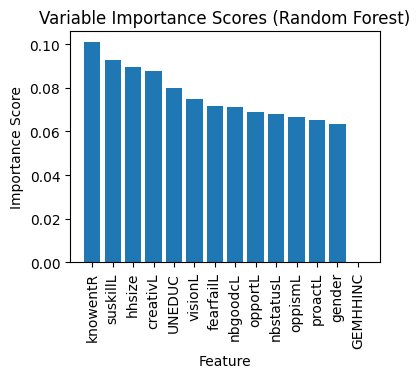

In [16]:
# Define a list of DataFrames
dfs = [df_lowInc, df_midInc, df_highInc]

# Loop over each DataFrame
for i, df in enumerate(dfs):
    print(f"Running model on DataFrame {i + 1}")

    # X contains features (independent variables), y contains the target variable (dependent variable)
    X = df.drop(columns=['FUTSUPNO'])
    y = df['FUTSUPNO']

    # Split Data into Training and Testing Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Initialize and train your model (e.g., DecisionTreeClassifier)
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_resampled, y_resampled)

    # Make predictions on the testing data
    y_pred_rf = rf_classifier.predict(X_test)

    # Report
    gen_report_accuracy(y_test, y_pred_rf)

    # CM
    confusM(y_test,y_pred_rf)

    # AUC ROC
    roc_auc_calc(rf_classifier,y_test)

    # Variable importance
    var_importance(rf_classifier, X_resampled,"Random Forest")

# Implementing the 3 economy types on XGBoost

Running model on DataFrame 1
Accuracy: 70.9967845659164 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81      2203
         1.0       0.50      0.28      0.36       907

    accuracy                           0.71      3110
   macro avg       0.63      0.58      0.59      3110
weighted avg       0.68      0.71      0.68      3110



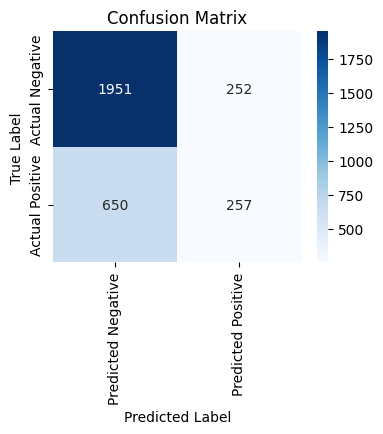


AUC-ROC Score: 0.6739196475088345


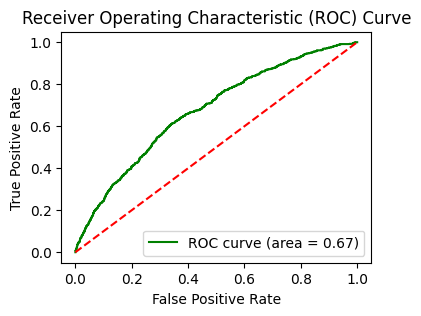

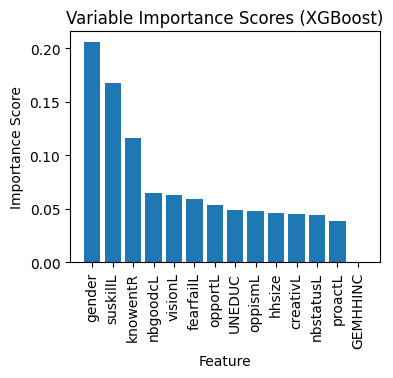


Running model on DataFrame 2
Accuracy: 70.79081632653062 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      2210
         1.0       0.51      0.35      0.41       926

    accuracy                           0.71      3136
   macro avg       0.63      0.60      0.61      3136
weighted avg       0.68      0.71      0.69      3136



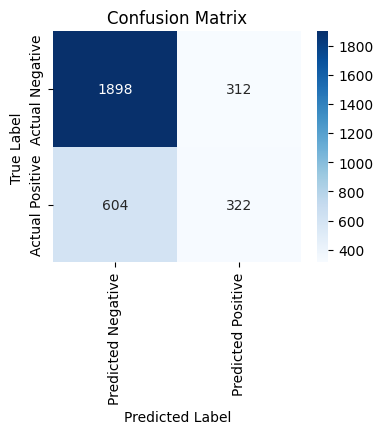


AUC-ROC Score: 0.6775883721157511


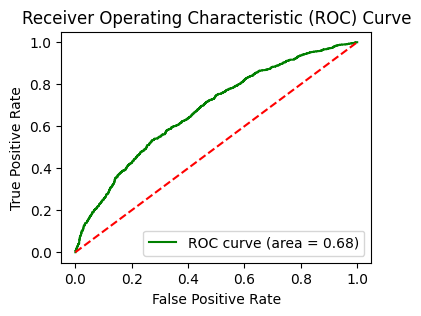

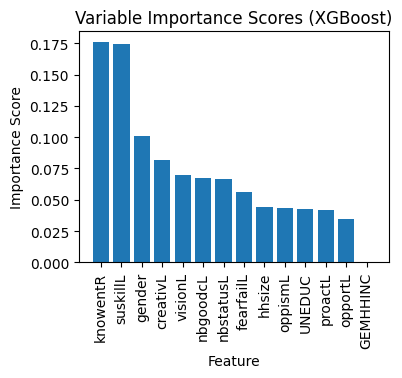


Running model on DataFrame 3
Accuracy: 71.01147028154328 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      2049
         1.0       0.49      0.33      0.39       828

    accuracy                           0.71      2877
   macro avg       0.63      0.60      0.60      2877
weighted avg       0.68      0.71      0.69      2877



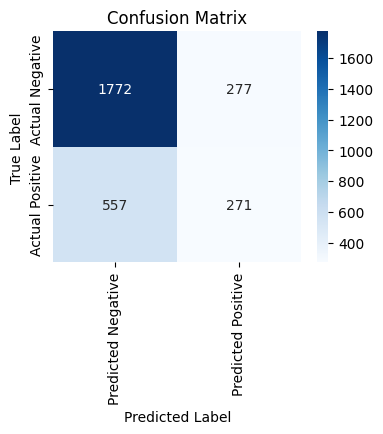


AUC-ROC Score: 0.6919087430418515


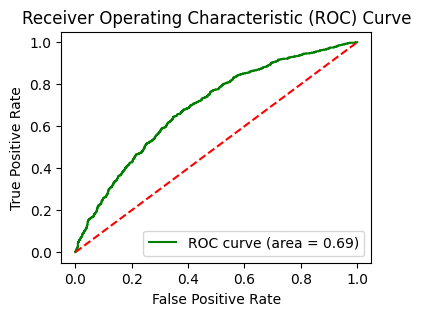

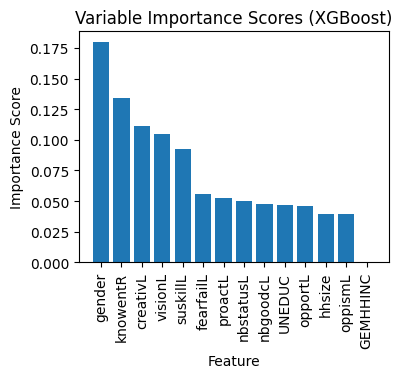

In [17]:
# Define a list of DataFrames
dfs = [df_lowInc, df_midInc, df_highInc]

# Loop over each DataFrame
for i, df in enumerate(dfs):
    print(f"Running model on DataFrame {i + 1}")

    # X contains features (independent variables), y contains the target variable (dependent variable)
    X = df.drop(columns=['FUTSUPNO'])
    y = df['FUTSUPNO']

    # Split Data into Training and Testing Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Initialize and train your model (e.g., DecisionTreeClassifier)
    xgb_classifier = xgb.XGBClassifier(random_state=42)

    # Fit the model to the training data
    xgb_classifier.fit(X_resampled, y_resampled)

    # predictions
    y_pred_xgb = xgb_classifier.predict(X_test)

    # Report
    gen_report_accuracy(y_test, y_pred_xgb)

    # CM
    confusM(y_test,y_pred_xgb)

    # AUC ROC
    roc_auc_calc(xgb_classifier,y_test)

    # Variable importance
    var_importance(xgb_classifier, X_resampled,"XGBoost")

gender      -0.081921
hhsize       0.075990
UNEDUC       0.051797
knowentR     0.210033
opportL      0.089789
suskillL     0.226448
fearfailL   -0.087820
oppismL     -0.003746
proactL     -0.047473
creativL     0.197981
visionL      0.181980
nbgoodcL     0.094984
nbstatusL    0.086324
GEMHHINC          NaN
dtype: float64


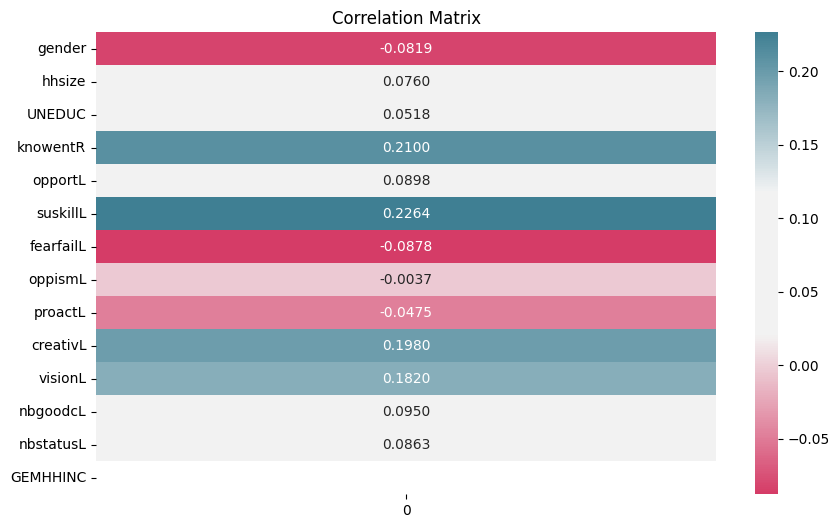

In [18]:
correlation_matrix = X_resampled.corrwith(y_resampled)

print(correlation_matrix)
# Define custom colormap
cmap = sns.diverging_palette(1, 220, sep=80, n=7, as_cmap=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap=cmap, fmt=".4f")
plt.title('Correlation Matrix')
plt.show()

## BELOW THIS POINT NOT APPLICABLE

# Model Implementation -- Decision Tree

In [ ]:
#  class weights
#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create an instance of the DecisionTreeClassifier class with class weights

# clf = DecisionTreeClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)), max_depth=depth)
clf = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
# clf.fit(X_train, y_train)
clf.fit(X_resampled, y_resampled)

#  predictions on the testing data
y_pred = clf.predict(X_test)

# report
gen_report_accuracy(y_test, y_pred)

# AUC ROC
roc_auc_calc(clf,y_test)

# confusion Matrix
confusM(y_test, y_pred)

# Variable importance
var_importance(clf, X_resampled)

# Model Implementation -- Random Forest

In [ ]:
# Instance of the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # adjust the number of trees (n_estimators)

# Fit the model to the training data
# rf_classifier.fit(X_train, y_train)
rf_classifier.fit(X_resampled, y_resampled)

# Make predictions on the testing data
y_pred_rf = rf_classifier.predict(X_test)

# Report
gen_report_accuracy(y_test, y_pred_rf)

# CM
confusM(y_test,y_pred_rf)

# AUC ROC
roc_auc_calc(rf_classifier,y_test)

# Variable importance
var_importance(rf_classifier, X_resampled)

# Model Implementation -- XGBoost

In [ ]:
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Fit the model to the training data
xgb_classifier.fit(X_resampled, y_resampled)

# predictions
y_pred_xgb = xgb_classifier.predict(X_test)

# Report
gen_report_accuracy(y_test, y_pred_xgb)

# CM
confusM(y_test,y_pred_xgb)

# AUC ROC
roc_auc_calc(xgb_classifier,y_test)

# Variable importance
var_importance(xgb_classifier, X_resampled)

# Feature Engineering and parameter tuning

* The irrelevant variables that were causing noise in the prediction were removed eg. GEMHHINC

# Model Implementation -- Neural Netowork

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.3)

# Make predictions on the testing data
y_pred_proba = model.predict(X_test)
y_pred_nn = (y_pred_proba > 0.5).astype(int)

In [ ]:
# Report
gen_report_accuracy(y_test, y_pred_nn)

# CM
confusM(y_test,y_pred_nn)
